In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
# data is from: https://grouplens.org/datasets/movielens/
# in case the link changes in the future

# !wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

In [4]:
# !unzip -n ml-20m.zip

In [5]:
# !ls

In [6]:
import os

In [7]:
os.getcwd()

'/Users/Z0094BV'

In [8]:
#df = pd.read_csv('ml-20m/ratings.csv')
df = pd.read_csv('ml-latest-small/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [9]:
#movie_titles = pd.read_csv('ml-20m/movies.csv')
movie_titles = pd.read_csv('ml-latest-small/movies.csv')
movie_titles.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
# We can't trust the userId and movieId to be numbered 0...N-1
# Let's just set our own ids

# current_user_id = 0
# custom_user_map = {} # old user id > new user id
# def map_user_id(row):
#   global current_user_id, custom_user_map
#   old_user_id = row['userId']
#   if old_user_id not in custom_user_map:
#     custom_user_map[old_user_id] = current_user_id
#     current_user_id += 1
#   return custom_user_map[old_user_id]

# df['new_user_id'] = df.apply(map_user_id, axis=1)

df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

In [11]:
#df.userId.cat.codes[56957]

In [12]:
#df.userId.cat.codes

In [13]:
#df['new_user_id'].shape

In [14]:
# Now do the same thing for movie ids
# current_movie_id = 0
# custom_movie_map = {} # old movie id > new movie id
# def map_movie_id(row):
#   global current_movie_id, custom_movie_map
#   old_movie_id = row['movieId']
#   if old_movie_id not in custom_movie_map:
#     custom_movie_map[old_movie_id] = current_movie_id
#     current_movie_id += 1
#   return custom_movie_map[old_movie_id]

# df['new_movie_id'] = df.apply(map_movie_id, axis=1)

df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [15]:
np.unique(df.movieId.cat.codes)

array([   0,    1,    2, ..., 9063, 9064, 9065], dtype=int16)

In [16]:
np.unique(df['movieId'])

array([     1,      2,      3, ..., 162542, 162672, 163949])

In [17]:
np.max(df['movieId'].astype(int))

163949

In [18]:
# Get user IDs, movie IDs, and ratings as separate arrays
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values - 2.5

In [19]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))

# Set embedding dimension
D = 10

In [20]:
# Make a neural network
class Model(nn.Module):
  def __init__(self, n_users, n_items, embed_dim, n_hidden=1024):
    super(Model, self).__init__()
    self.N = n_users
    self.M = n_items
    self.D = embed_dim

    self.u_emb = nn.Embedding(self.N, self.D)
    self.m_emb = nn.Embedding(self.M, self.D)
    self.fc1 = nn.Linear(2 * self.D, n_hidden)
    self.fc2 = nn.Linear(n_hidden, 1)

    # set the weights since N(0, 1) leads to poor results
    self.u_emb.weight.data = nn.Parameter(
        torch.Tensor(np.random.randn(self.N, self.D) * 0.01))
    self.m_emb.weight.data = nn.Parameter(
        torch.Tensor(np.random.randn(self.M, self.D) * 0.01))
  
  def forward(self, u, m):
    u = self.u_emb(u) # output is (num_samples, D)
    m = self.m_emb(m) # output is (num_samples, D)

    # merge
    out = torch.cat((u, m), 1) # output is (num_samples, 2D)

    # ANN
    out = self.fc1(out)
    out = F.relu(out)
    out = self.fc2(out)
    return out

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [22]:
model = Model(N, M, D)
model.to(device)

Model(
  (u_emb): Embedding(671, 10)
  (m_emb): Embedding(9066, 10)
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)

In [23]:
# Loss and optimizer
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.9)

In [24]:
def batch_gd2(model, criterion, optimizer, train_data, test_data, epochs, bs=512):
  train_users, train_movies, train_ratings = train_data
  test_users, test_movies, test_ratings = test_data

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  # batches per epoch
  Ntrain = len(train_users)
  batches_per_epoch = int(np.ceil(Ntrain / bs))

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []

    # shuffle each batch
    train_users, train_movies, train_ratings = shuffle(
        train_users, train_movies, train_ratings
    )

    for j in range(batches_per_epoch):
      # get the batch
      users = train_users[j*bs:(j+1)*bs]
      movies = train_movies[j*bs:(j+1)*bs]
      targets = train_ratings[j*bs:(j+1)*bs]

      # convert to tensor
      users = torch.from_numpy(users).long()
      movies = torch.from_numpy(movies).long()
      targets = torch.from_numpy(targets)
    
      # reshape targets
      targets = targets.view(-1, 1).float()

      # move data to GPU
      users, movies, targets = users.to(device), movies.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(users, movies)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
    
    # we could do this if the test set size was manageable
    # test_outputs = model(test_users, test_movies)
    # test_loss = criterion(test_outputs, test_ratings).item()
    test_loss = []
    for j in range(int(np.ceil(len(test_users) / bs))):
      # get the batch
      users = test_users[j*bs:(j+1)*bs]
      movies = test_movies[j*bs:(j+1)*bs]
      targets = test_ratings[j*bs:(j+1)*bs]

      # conver to tensor
      users = torch.from_numpy(users).long()
      movies = torch.from_numpy(movies).long()
      targets = torch.from_numpy(targets)
    
      # reshape targets
      targets = targets.view(-1, 1).float()

      # move data to GPU
      users, movies, targets = users.to(device), movies.to(device), targets.to(device)

      outputs = model(users, movies)
      loss = criterion(outputs, targets).item()
      test_loss.append(loss)
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test RMSE: {np.sqrt(test_loss):.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [25]:
# shuffle the data in corresponding order
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)

In [26]:
Ntrain = int(0.75 * len(ratings))
train_users = user_ids[:Ntrain]
train_movies = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_users = user_ids[Ntrain:]
test_movies = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

train_losses, test_losses = batch_gd2(
    model,
    criterion,
    optimizer,
    (train_users, train_movies, train_ratings),
    (test_users, test_movies, test_ratings),
    epochs=10)

Epoch 1/10, Train Loss: 1.0377, Test Loss: 0.8340, Test RMSE: 0.9132, Duration: 0:00:00.694932
Epoch 2/10, Train Loss: 0.8072, Test Loss: 0.7952, Test RMSE: 0.8917, Duration: 0:00:00.736841
Epoch 3/10, Train Loss: 0.7554, Test Loss: 0.7935, Test RMSE: 0.8908, Duration: 0:00:00.683794
Epoch 4/10, Train Loss: 0.7204, Test Loss: 0.7739, Test RMSE: 0.8797, Duration: 0:00:00.660207
Epoch 5/10, Train Loss: 0.6986, Test Loss: 0.7796, Test RMSE: 0.8830, Duration: 0:00:00.622400
Epoch 6/10, Train Loss: 0.6831, Test Loss: 0.7816, Test RMSE: 0.8841, Duration: 0:00:00.655083
Epoch 7/10, Train Loss: 0.6696, Test Loss: 0.7722, Test RMSE: 0.8787, Duration: 0:00:00.648430
Epoch 8/10, Train Loss: 0.6604, Test Loss: 0.7941, Test RMSE: 0.8911, Duration: 0:00:00.627179
Epoch 9/10, Train Loss: 0.6475, Test Loss: 0.7886, Test RMSE: 0.8880, Duration: 0:00:00.641276
Epoch 10/10, Train Loss: 0.6312, Test Loss: 0.7812, Test RMSE: 0.8839, Duration: 0:00:00.628338


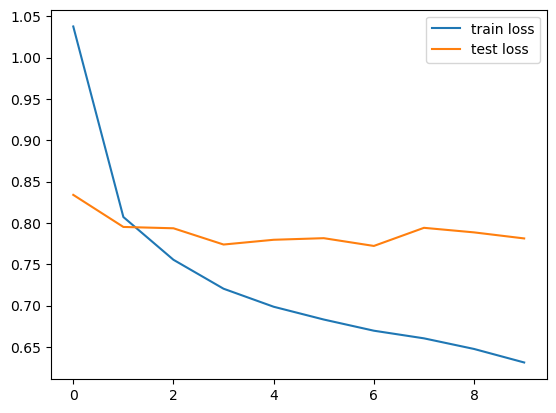

In [27]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [28]:
# Suppose I want to find recommendations for user_id = 1
# First find all the movie_ids for movies they haven't yet watched
# watched_movie_ids = df[df.new_user_id == 1].new_movie_id.values


new_user = 409

watched_movie_ids = df[df.new_user_id == new_user].new_movie_id.values

In [29]:
watched_movie_ids

array([   0,   31,   32,  100,  144,  203,  232,  266,  282,  284,  309,
        321,  341,  344,  427,  447,  472,  535,  561,  955, 1019, 1024,
       2062, 3869, 4121, 4391, 5485, 5611], dtype=int16)

In [30]:
old_user = np.unique(df[df['new_user_id'].isin([new_user])]['userId'])[0]
old_user

410

In [31]:
old_watched_movie_ids = np.unique(df[df.userId == old_user].movieId.values)
old_watched_movie_ids

array([   1,   32,   34,  110,  165,  231,  260,  296,  316,  318,  344,
        356,  377,  380,  480,  500,  527,  608,  648, 1198, 1265, 1270,
       2571, 4993, 5418, 5952, 8665, 8961])

In [32]:
potential_movie_ids = df[~df.new_movie_id.isin(watched_movie_ids)].new_movie_id.unique()
potential_movie_ids

array([  30,  833,  859, ...,  115, 3712, 4629], dtype=int16)

In [33]:
# How many?
potential_movie_ids.shape

(9038,)

In [34]:
len(set(potential_movie_ids))

9038

In [35]:
# Repeat the user id this many times
user_id_to_recommend = np.ones_like(potential_movie_ids)

In [36]:
# Convert to torch tensor
t_user_ids = torch.from_numpy(user_id_to_recommend).long().to(device)
t_movie_ids = torch.from_numpy(potential_movie_ids).long().to(device)

# Get predictions
with torch.no_grad():
  predictions = model(t_user_ids, t_movie_ids)

In [37]:
# Convert predictions to Numpy
predictions_np = predictions.cpu().numpy().flatten()

# Get sort index for predictions
sort_idx = np.argsort(-predictions_np)

In [38]:
predictions_np

array([0.8159396 , 1.0749307 , 0.81918776, ..., 1.0039877 , 1.0240043 ,
       0.54169416], dtype=float32)

In [39]:
sort_idx

array([1647,  898,  968, ..., 3895, 4392, 5497])

In [40]:
# Top 10 predictions
top_10_movie_ids = potential_movie_ids[sort_idx[:10]]
top_10_scores = predictions_np[sort_idx[:10]]

for movie, score in zip(top_10_movie_ids, top_10_scores):
  print("movie:", movie, "score:", score)

movie: 7783 score: 1.5996474
movie: 2038 score: 1.5882685
movie: 2520 score: 1.5855536
movie: 720 score: 1.5845242
movie: 980 score: 1.584472
movie: 4134 score: 1.5748942
movie: 1973 score: 1.5741311
movie: 954 score: 1.5608971
movie: 5162 score: 1.5528014
movie: 2688 score: 1.5462657


In [41]:
top_10_movie_ids

array([7783, 2038, 2520,  720,  980, 4134, 1973,  954, 5162, 2688],
      dtype=int16)

In [42]:
old_top_10_movie_ids = np.unique(df[df['new_movie_id'].isin(top_10_movie_ids)]['movieId'])
old_top_10_movie_ids

array([  899,  1197,  1224,  2467,  2542,  3134,  3362,  5444,  7502,
       86882])

In [43]:
#df[['']]

In [44]:
#movie_titles = pd.read_csv('ml-latest-small/movies.csv')
#movie_titles.head()

In [45]:
movie_titles[movie_titles['movieId'].isin(old_watched_movie_ids)]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
32,34,Babe (1995),Children|Drama
100,110,Braveheart (1995),Action|Drama|War
144,165,Die Hard: With a Vengeance (1995),Action|Crime|Thriller
203,231,Dumb & Dumber (Dumb and Dumber) (1994),Adventure|Comedy
232,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
266,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
282,316,Stargate (1994),Action|Adventure|Sci-Fi
284,318,"Shawshank Redemption, The (1994)",Crime|Drama


In [46]:
user_recos = movie_titles[movie_titles['movieId'].isin(old_top_10_movie_ids)].reset_index(drop=True)
user_recos

,movieId,title,genres
0,899,Singin' in the Rain (1952),Comedy|Musical|Romance
1,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance
2,1224,Henry V (1989),Action|Drama|Romance|War
3,2467,"Name of the Rose, The (Name der Rose, Der) (1986)",Crime|Drama|Mystery|Thriller
4,2542,"Lock, Stock & Two Smoking Barrels (1998)",Comedy|Crime|Thriller
5,3134,Grand Illusion (La grande illusion) (1937),Drama|War
6,3362,Dog Day Afternoon (1975),Crime|Drama
7,5444,Lilo & Stitch (2002),Adventure|Animation|Children|Sci-Fi
8,7502,Band of Brothers (2001),Action|Drama|War
9,86882,Midnight in Paris (2011),Comedy|Fantasy|Romance


In [47]:
print("We recommend: \n")
for i in range(len(user_recos)):
    print(user_recos['title'][i])

We recommend: 

Singin' in the Rain (1952)
Princess Bride, The (1987)
Henry V (1989)
Name of the Rose, The (Name der Rose, Der) (1986)
Lock, Stock & Two Smoking Barrels (1998)
Grand Illusion (La grande illusion) (1937)
Dog Day Afternoon (1975)
Lilo & Stitch (2002)
Band of Brothers (2001)
Midnight in Paris (2011)


In [48]:
#df[df['userId']==410]

In [49]:
df.head()

,userId,movieId,rating,timestamp,new_user_id,new_movie_id
0,1,31,2.5,1260759144,0,30
1,1,1029,3.0,1260759179,0,833
2,1,1061,3.0,1260759182,0,859
3,1,1129,2.0,1260759185,0,906
4,1,1172,4.0,1260759205,0,931


In [50]:
len(np.unique(df['movieId']))

9066

In [51]:
len(np.unique(df['new_movie_id']))

9066

In [52]:
len(np.unique(df[['movieId']]))

9066

In [53]:
len(np.unique(df[['new_movie_id']]))

9066

In [54]:
model.m_emb.weight.data

tensor([[-0.0137,  0.1562, -0.0100,  ...,  0.0435,  0.0549,  0.0443],
        [-0.0012,  0.0149,  0.0180,  ...,  0.0131, -0.0140,  0.0126],
        [ 0.1137, -0.0670,  0.0244,  ..., -0.0743, -0.0406, -0.0375],
        ...,
        [-0.0453,  0.0298, -0.0053,  ...,  0.0792,  0.0394,  0.0666],
        [ 0.0248, -0.0257,  0.0123,  ..., -0.0212, -0.0218, -0.0508],
        [-0.0678,  0.0300, -0.0187,  ...,  0.0781,  0.0807,  0.1019]])

In [55]:
m_emb_df = pd.DataFrame(model.m_emb.weight.data)
m_emb_df.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.013696,0.156197,-0.009955,-0.034928,-0.052934,-0.029280,0.071881,0.043481,0.054877,0.044257
1,-0.001244,0.014875,0.018000,0.011645,-0.012792,0.010926,-0.010243,0.013097,-0.014040,0.012579
2,0.113731,-0.067038,0.024434,0.092586,-0.047690,0.077882,0.043531,-0.074308,-0.040595,-0.037475
3,0.032022,-0.029657,-0.002260,-0.077996,-0.041772,0.026145,0.012840,-0.094132,-0.083216,-0.132518
4,0.020552,-0.011205,-0.013929,-0.013049,-0.001065,-0.023355,0.001326,-0.034759,-0.000109,-0.054455


In [56]:
m_emb_df['movieId'] = np.unique(df[['movieId']])

In [57]:
m_emb_df['new_movie_id'] = np.unique(df[['new_movie_id']])

In [58]:
m_emb_df.shape

(9066, 12)

In [59]:
m_emb_df.head()

,0,1,2,3,4,5,6,7,8,9,movieId,new_movie_id
0,-0.013696,0.156197,-0.009955,-0.034928,-0.052934,-0.029280,0.071881,0.043481,0.054877,0.044257,1,0
1,-0.001244,0.014875,0.018000,0.011645,-0.012792,0.010926,-0.010243,0.013097,-0.014040,0.012579,2,1
2,0.113731,-0.067038,0.024434,0.092586,-0.047690,0.077882,0.043531,-0.074308,-0.040595,-0.037475,3,2
3,0.032022,-0.029657,-0.002260,-0.077996,-0.041772,0.026145,0.012840,-0.094132,-0.083216,-0.132518,4,3
4,0.020552,-0.011205,-0.013929,-0.013049,-0.001065,-0.023355,0.001326,-0.034759,-0.000109,-0.054455,5,4


In [60]:
m_emb_df = pd.merge(m_emb_df, movie_titles, how='inner', left_on = ['movieId'], right_on = ['movieId'], right_index = False)


In [61]:
m_emb_df.head()

,0,1,2,3,4,5,6,7,8,9,movieId,new_movie_id,title,genres
0,-0.013696,0.156197,-0.009955,-0.034928,-0.052934,-0.029280,0.071881,0.043481,0.054877,0.044257,1,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,-0.001244,0.014875,0.018000,0.011645,-0.012792,0.010926,-0.010243,0.013097,-0.014040,0.012579,2,1,Jumanji (1995),Adventure|Children|Fantasy
2,0.113731,-0.067038,0.024434,0.092586,-0.047690,0.077882,0.043531,-0.074308,-0.040595,-0.037475,3,2,Grumpier Old Men (1995),Comedy|Romance
3,0.032022,-0.029657,-0.002260,-0.077996,-0.041772,0.026145,0.012840,-0.094132,-0.083216,-0.132518,4,3,Waiting to Exhale (1995),Comedy|Drama|Romance
4,0.020552,-0.011205,-0.013929,-0.013049,-0.001065,-0.023355,0.001326,-0.034759,-0.000109,-0.054455,5,4,Father of the Bride Part II (1995),Comedy


In [62]:
# Principal Component Analysis to represent word embeddings in 2-D
from sklearn.decomposition import PCA
from matplotlib import pyplot
X = model.m_emb.weight.data
pca = PCA(n_components=2)
result = pca.fit_transform(X)

In [63]:
#result_sample = result.sample(50)

In [64]:
list(m_emb_df['title'][0:50])

['Toy Story (1995)',
 'Jumanji (1995)',
 'Grumpier Old Men (1995)',
 'Waiting to Exhale (1995)',
 'Father of the Bride Part II (1995)',
 'Heat (1995)',
 'Sabrina (1995)',
 'Tom and Huck (1995)',
 'Sudden Death (1995)',
 'GoldenEye (1995)',
 'American President, The (1995)',
 'Dracula: Dead and Loving It (1995)',
 'Balto (1995)',
 'Nixon (1995)',
 'Cutthroat Island (1995)',
 'Casino (1995)',
 'Sense and Sensibility (1995)',
 'Four Rooms (1995)',
 'Ace Ventura: When Nature Calls (1995)',
 'Money Train (1995)',
 'Get Shorty (1995)',
 'Copycat (1995)',
 'Assassins (1995)',
 'Powder (1995)',
 'Leaving Las Vegas (1995)',
 'Othello (1995)',
 'Now and Then (1995)',
 'Persuasion (1995)',
 'City of Lost Children, The (Cité des enfants perdus, La) (1995)',
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 'Dangerous Minds (1995)',
 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)',
 'Babe (1995)',
 'Carrington (1995)',
 'Dead Man Walking (1995)',
 'Across the Sea of Time (1995)',
 'It Takes Two

In [65]:
result[:50, 0]

array([ 8.96493281e-02,  2.63406550e-04, -1.65526224e-01, -1.78757342e-01,
       -4.33860249e-02,  8.40491136e-02, -6.02849541e-02,  6.93905771e-02,
       -1.53875769e-01, -6.07034272e-02,  1.17711043e-02, -1.70241896e-01,
        1.30443550e-01, -6.13001176e-03, -2.78334907e-01,  1.88382589e-01,
        1.85016264e-01, -5.00540750e-02, -2.04059796e-01, -2.07516421e-01,
        4.71353084e-02, -7.75065587e-02, -1.63886126e-01, -8.54877549e-02,
        1.77263318e-01,  1.20062902e-01, -6.47582856e-02,  9.29861418e-02,
        1.36412737e-01,  1.45223216e-01, -8.22973868e-02,  1.52490447e-01,
        5.47973276e-02,  7.44352050e-03,  1.88546936e-01, -2.43716778e-01,
       -1.05017868e-02,  1.17228779e-01,  9.83440896e-02,  2.19837770e-01,
       -1.93048259e-01,  3.57815841e-02, -1.02253388e-01,  4.06935042e-02,
       -5.55752837e-02,  1.66541124e-01, -7.07799436e-02, -6.36009832e-02,
        3.14355722e-01,  6.09399663e-02])

In [66]:
result[:50, 1]

array([-0.01129839, -0.03193553, -0.05558331,  0.09406982,  0.04478759,
        0.03131963, -0.06122588, -0.04337716,  0.00680285,  0.0091767 ,
       -0.01470872,  0.03050901,  0.00730816,  0.12723945,  0.06505083,
        0.00229829, -0.03739265, -0.08212174,  0.03196666,  0.03162923,
        0.07897311,  0.03862391, -0.06518308, -0.11432951,  0.04695735,
       -0.02386651,  0.0124282 , -0.11916636, -0.04801609, -0.05675408,
        0.02624354,  0.02756072, -0.03242184,  0.0092871 , -0.00092417,
        0.03023035, -0.01184083,  0.01346411, -0.02680712,  0.02232692,
       -0.01080991,  0.00658237,  0.01659472,  0.0992593 , -0.00563153,
        0.029686  ,  0.11268743, -0.00142434, -0.01901151,  0.08421248])

In [67]:
m_emb_df['pca_1'] = result[:, 0]
m_emb_df['pca_2'] = result[:, 1]

In [68]:
m_emb_df.head()

,0,1,2,3,4,5,6,7,8,9,movieId,new_movie_id,title,genres,pca_1,pca_2
0,-0.013696,0.156197,-0.009955,-0.034928,-0.052934,-0.029280,0.071881,0.043481,0.054877,0.044257,1,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.089649,-0.011298
1,-0.001244,0.014875,0.018000,0.011645,-0.012792,0.010926,-0.010243,0.013097,-0.014040,0.012579,2,1,Jumanji (1995),Adventure|Children|Fantasy,0.000263,-0.031936
2,0.113731,-0.067038,0.024434,0.092586,-0.047690,0.077882,0.043531,-0.074308,-0.040595,-0.037475,3,2,Grumpier Old Men (1995),Comedy|Romance,-0.165526,-0.055583
3,0.032022,-0.029657,-0.002260,-0.077996,-0.041772,0.026145,0.012840,-0.094132,-0.083216,-0.132518,4,3,Waiting to Exhale (1995),Comedy|Drama|Romance,-0.178757,0.094070
4,0.020552,-0.011205,-0.013929,-0.013049,-0.001065,-0.023355,0.001326,-0.034759,-0.000109,-0.054455,5,4,Father of the Bride Part II (1995),Comedy,-0.043386,0.044788


In [69]:
m_emb_df['year'] = pd.to_numeric(m_emb_df['title'].str[-6::].str.replace("(",'').str.replace(")",'').str.replace("-",''), errors='coerce').fillna(0).astype('int')
m_emb_df.head()


/var/folders/0y/mqv6hsyx3xq_llz15k7nfxxc0000gp/T/ipykernel_33401/616065709.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  m_emb_df['year'] = pd.to_numeric(m_emb_df['title'].str[-6::].str.replace("(",'').str.replace(")",'').str.replace("-",''), errors='coerce').fillna(0).astype('int')


,0,1,2,3,4,5,6,7,8,9,movieId,new_movie_id,title,genres,pca_1,pca_2,year
0,-0.013696,0.156197,-0.009955,-0.034928,-0.052934,-0.029280,0.071881,0.043481,0.054877,0.044257,1,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.089649,-0.011298,1995
1,-0.001244,0.014875,0.018000,0.011645,-0.012792,0.010926,-0.010243,0.013097,-0.014040,0.012579,2,1,Jumanji (1995),Adventure|Children|Fantasy,0.000263,-0.031936,1995
2,0.113731,-0.067038,0.024434,0.092586,-0.047690,0.077882,0.043531,-0.074308,-0.040595,-0.037475,3,2,Grumpier Old Men (1995),Comedy|Romance,-0.165526,-0.055583,1995
3,0.032022,-0.029657,-0.002260,-0.077996,-0.041772,0.026145,0.012840,-0.094132,-0.083216,-0.132518,4,3,Waiting to Exhale (1995),Comedy|Drama|Romance,-0.178757,0.094070,1995
4,0.020552,-0.011205,-0.013929,-0.013049,-0.001065,-0.023355,0.001326,-0.034759,-0.000109,-0.054455,5,4,Father of the Bride Part II (1995),Comedy,-0.043386,0.044788,1995


In [70]:
m_emb_df_sample = m_emb_df[(m_emb_df['year'] >= 2000) & ((m_emb_df['pca_1'] >= 0.15)  | (m_emb_df['pca_1'] <= -0.188118)) & 
                           ((m_emb_df['pca_2'] >= 0.04) | (m_emb_df['pca_2'] <= -0.04))]#.sample(80)



In [71]:
m_emb_df_sample.describe()

,0,1,2,3,4,5,6,7,8,9,movieId,new_movie_id,pca_1,pca_2,year
count,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,-0.012015,0.004140,-0.008616,-0.014320,0.014503,-0.011238,-0.004925,0.011705,0.014755,0.015353,46044.753623,6007.963768,0.034549,0.012513,2005.978261
std,0.060357,0.038889,0.041615,0.055593,0.067087,0.064051,0.030051,0.088989,0.100256,0.119035,40924.146032,1825.044443,0.211479,0.073509,4.555365
min,-0.105589,-0.075630,-0.106793,-0.153947,-0.105688,-0.099736,-0.063725,-0.179789,-0.167814,-0.232281,3481.000000,2780.000000,-0.351226,-0.118960,2000.000000
25%,-0.063940,-0.033283,-0.044477,-0.062366,-0.048852,-0.062107,-0.030888,-0.062090,-0.099893,-0.118603,5791.750000,4308.750000,-0.207345,-0.051797,2002.000000
50%,-0.039167,0.015580,-0.006659,-0.008976,0.030882,-0.044081,-0.009584,0.031357,0.060522,0.080602,44568.000000,6380.500000,0.160766,0.042068,2006.000000
75%,0.054224,0.034264,0.030145,0.031376,0.072727,0.059173,0.025790,0.091558,0.095899,0.104788,84603.750000,7723.500000,0.192240,0.067697,2010.000000
max,0.105090,0.093815,0.058091,0.099670,0.133901,0.103019,0.051264,0.149974,0.159634,0.170737,152057.000000,9016.000000,0.329054,0.203913,2016.000000


In [72]:
## # create a scatter plot of the projection
## pyplot.scatter(result[:50, 0], result[:50, 1])
## words = list(m_emb_df['title'][0:50])
## #plt.figure(figsize=(5,5))
## for i, word in enumerate(words):
##     pyplot.annotate(words, xy=(result[i, 0], result[i, 1]))
## 
## #pyplot.rcParams['figure.figsize'] = [10, 10]
## pyplot.show()

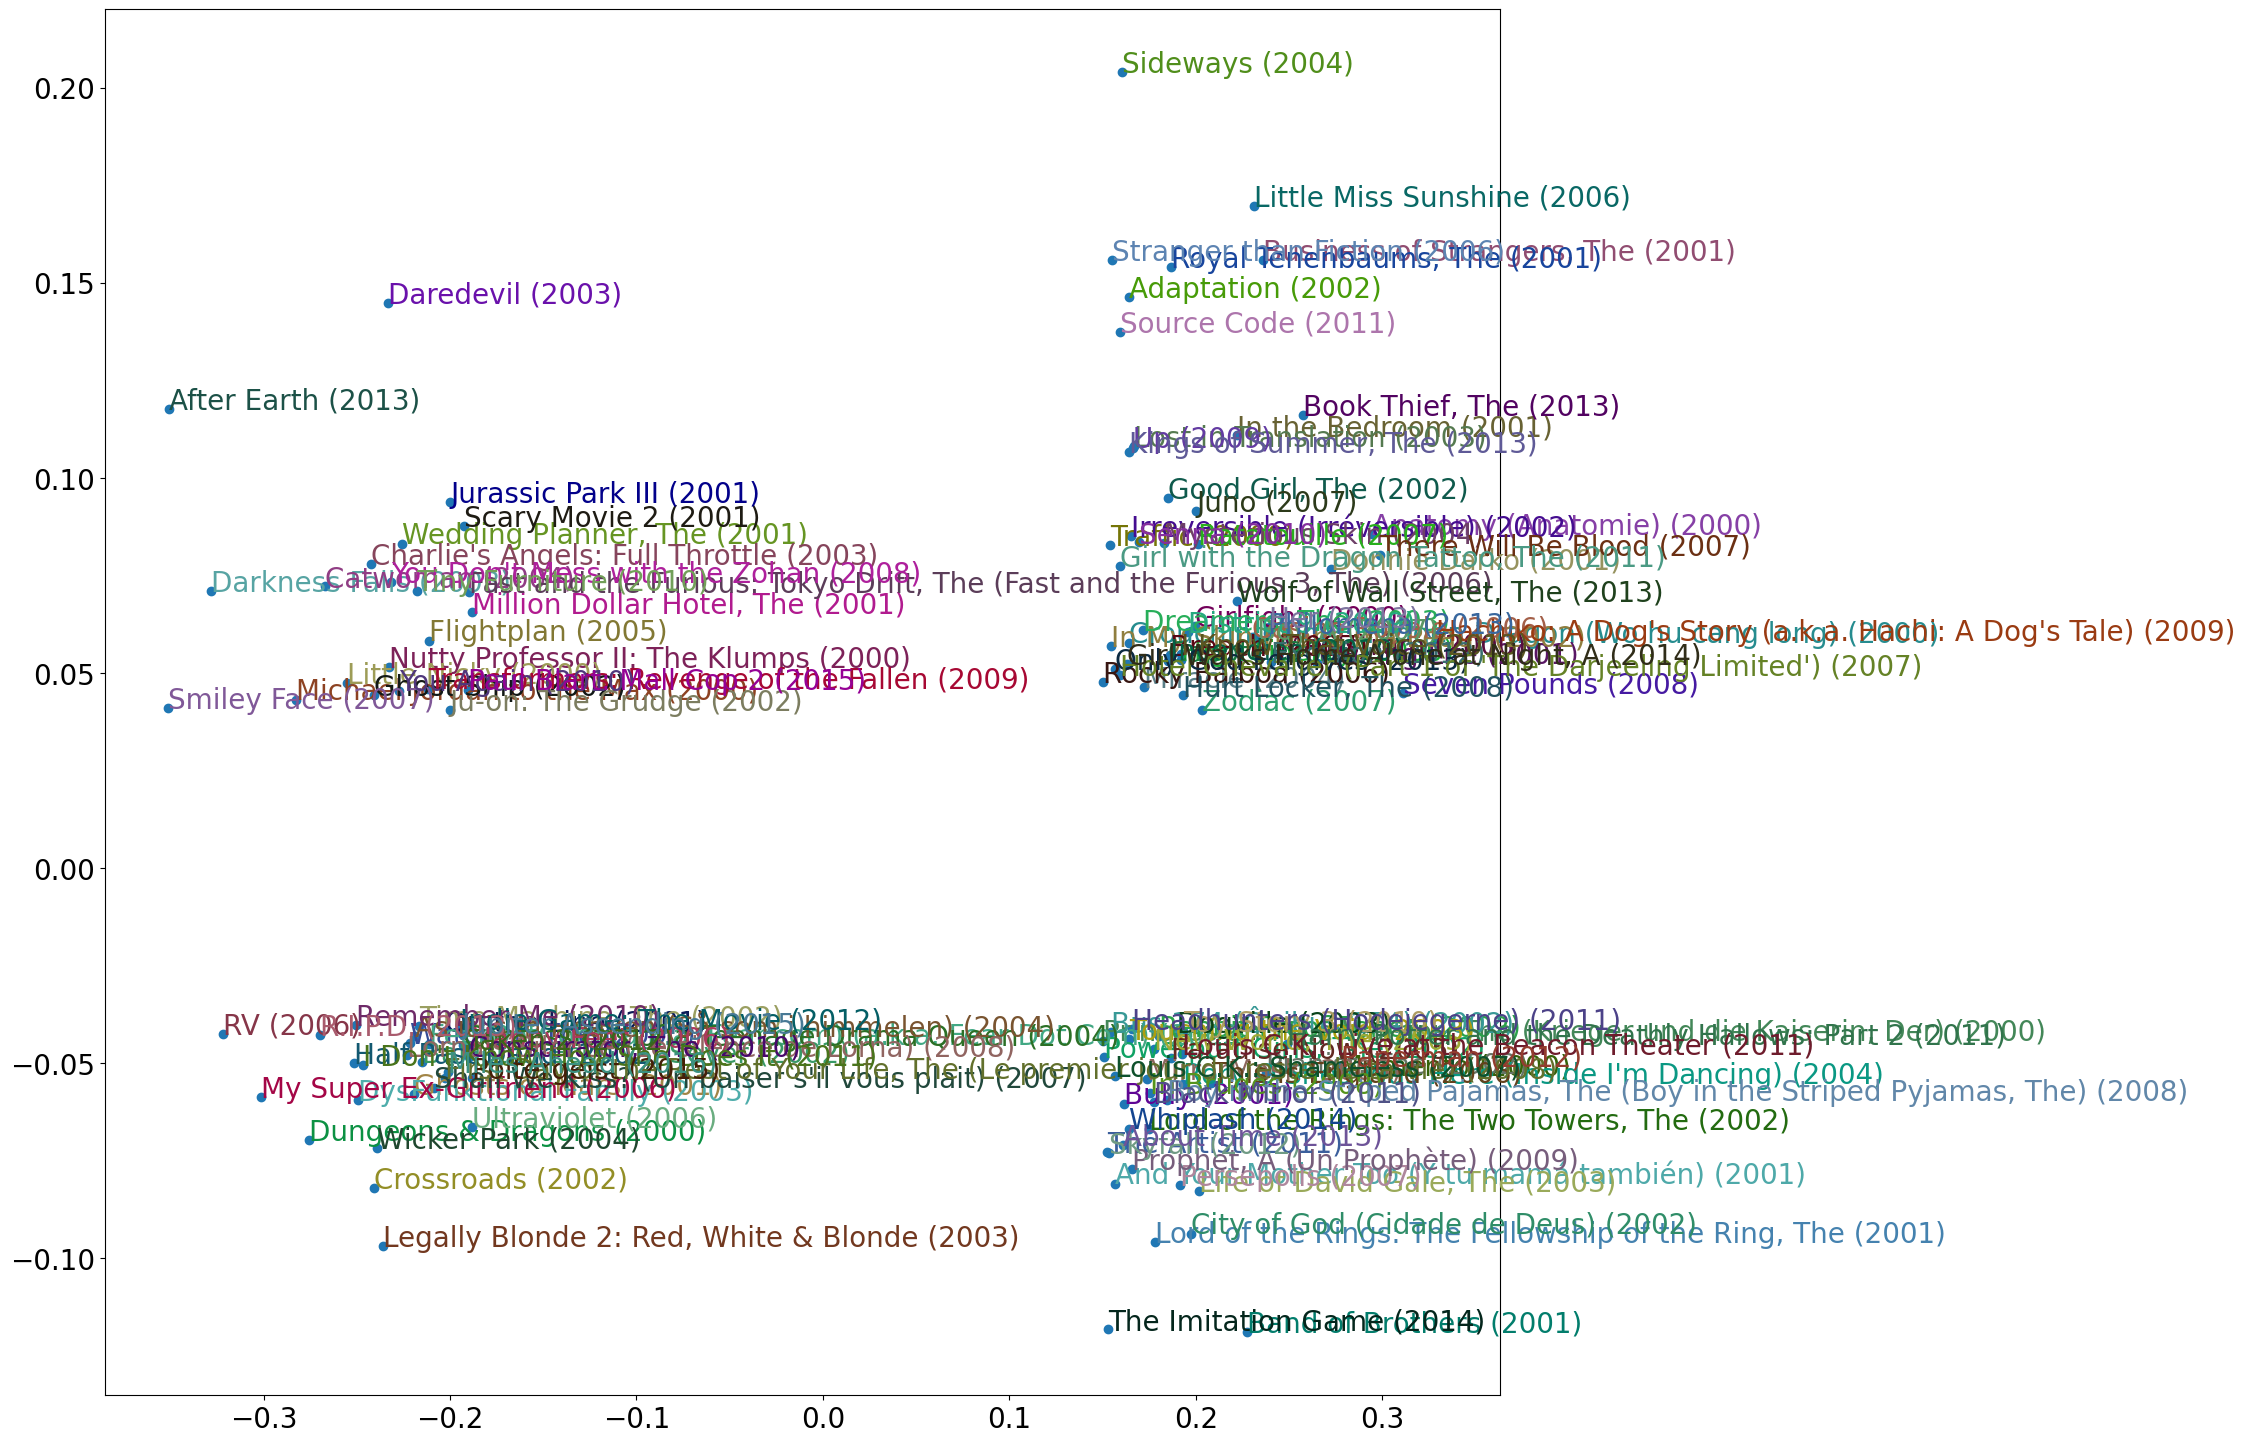

In [73]:
#idxs = np.random.choice(len(top_movies), 50, replace=False)
#idxs = list(range(50))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

X = m_emb_df_sample['pca_1'] #fac0[idxs]
Y = m_emb_df_sample['pca_2'] #fac2[idxs]
plt.figure(figsize=(18,18))
plt.scatter(X, Y)
for i, x, y in zip(list(m_emb_df_sample['title']), X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=20)
plt.show()